In [ ]:
import joblib
import os

from dotenv import load_dotenv
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from google import genai
import pandas as pd
import numpy as np
import spacy

load_dotenv()
path = "../data/processed/market_products_features.csv"
dtypes = {"sku": str, "gtin": str}
df = pd.read_csv(path, dtype=dtypes, index_col=0, sep="|")
df.sample()

,sku,gtin,specifications,brand,description,product_name,review_tags,category_name,root_category_name,main_image,...,size_w,size_h,size_units,weight,weight_unit,weight_kg,weight_kg_mean,size_l_mean,size_w_mean,size_h_mean
514,1743897163,196901004947,"[{""name"":""Brand"",""value"":""Comfort Canopy""},{""n...",Comfort Canopy,FEATURES: Soft and Cozy - Made from 100% 9...,Comfort Canopy - 4 Piece Gray Chevron Printed ...,"[""Softness (8)"",""Color (5)"",""Feel (4)"",""Sets (...",Bed Sheets,Home,"""https://i5.walmartimages.com/seo/Comfort-Cano...",...,72.0,0.1,in,0.1,lb,0.04536,3.49,54.0,48.4,7.1


Las siguientes son posibles candidatos para embeddings
* specifications (limpiar)
* description
* product_name
* sizes (limpiar)

In [2]:
df["weight_kg"].describe()

count    211.000000
mean       3.807651
std        8.942950
min        0.005377
25%        0.369684
50%        1.238328
75%        2.184084
max       57.380400
Name: weight_kg, dtype: float64

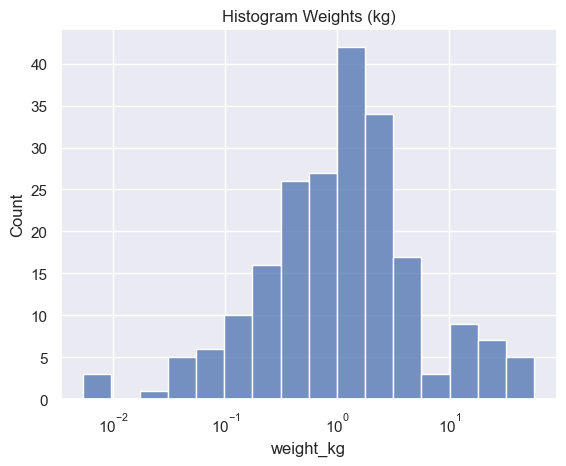

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
sns.histplot(df["weight_kg"], log_scale=True)
plt.title("Histogram Weights (kg)")
plt.show()

El pequeño tamaño de la muestra, o la asimetria en la distribusion del peso puede ser un reto para los modelos, una libreria como [smogn](https://pypi.org/project/smogn/) puede dar como resultado mejores modelos.

# Embeddings

In [4]:
nlp = spacy.load("en_core_web_md")
nlp.disable_pipes("parser", "ner")
print(nlp.pipe_names)

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']


In [5]:
# Genera los vectores usando el modelo de spacy
df["product_name_vector"] = df["product_name"].apply(lambda x: nlp(x).vector)
df["product_name_vector"].head()

0    [-0.6645359, 0.25058463, -0.085736245, 0.30602...
1    [-0.5852896, 0.021247137, -0.16949064, -0.0435...
2    [-0.65554154, 0.14395839, -0.02887265, 0.15746...
3    [-0.67238826, -0.06380527, -0.15272984, 0.0498...
4    [-0.7162662, 0.047542773, -0.10108063, 0.02942...
Name: product_name_vector, dtype: object

# Training data

In [6]:
print(df["weight_kg"].notna().sum(), df["weight_kg_mean"].notna().sum())
has_weight = df["weight_kg"].notna()
df[has_weight].sample(3)

211 878


,sku,gtin,specifications,brand,description,product_name,review_tags,category_name,root_category_name,main_image,...,size_h,size_units,weight,weight_unit,weight_kg,weight_kg_mean,size_l_mean,size_w_mean,size_h_mean,product_name_vector
532,3499753228,463499753220,"[{""name"":""Brand"",""value"":""Amay's""},{""name"":""Cu...",Amay's,PACKAGE CONTAINS : Black 84 Inch Wide by 84...,Amay Rod Pocket Window Curtain Panel Black 84 ...,[],Black Curtains,Home,"""https://i5.walmartimages.com/seo/Amay-Rod-Poc...",...,0.1,in,5.00,lb,2.268000,3.49,54.0,48.4,7.1,"[-0.6309234, 0.26011464, 0.16697913, 0.1250069..."
9,5108346618,749655398086,"[{""name"":""Brand"",""value"":""Amolife""},{""name"":""C...",Amolife,Features: Sophisticated Design:&nbsp;Uphol...,Amolife King Size Upholstered Platform Bed Fra...,"[""Assembly (4)""]",King Beds,Home,"""https://i5.walmartimages.com/seo/Amolife-King...",...,47.0,in,75.18,lb,34.101648,3.49,54.0,48.4,7.1,"[-0.62231416, 0.22903349, -0.15973325, 0.16433..."
132,1638119585,840105728504,"[{""name"":""Brand"",""value"":""Bare Home""},{""name"":...",Bare Home,Dimensions &amp; Contents: Includes 1 King...,"Bare Home Fitted Sheet - 22"" Extra Deep Pocket...","[""Fit (53)"",""Softness (28)"",""Mattress (26)"",""P...",Colored Sheets,Home,"""https://i5.walmartimages.com/seo/Bare-Home-Fi...",...,22.0,in,2.00,lb,0.907200,3.49,54.0,48.4,7.1,"[-0.7031863, 0.17031986, 0.0021459097, -0.1022..."


In [7]:
df_train = df[has_weight].copy()
df_predict = df[~has_weight].copy()
print(df_train.shape)
print(df_predict.shape)

(211, 29)
(689, 29)


# Models weight

In [31]:
def show_model_metrics(y_test, y_pred):
    # Calculate metrics for model
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("\nModel Performance Report:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Median Absolute Error: {medae:.4f}")
    print(f"R^2 Score: {r2:.4f}")

In [8]:
def save_model(model, filename):
    """
    Save a trained model to disk using joblib.

    Parameters:
        model: Trained model object (e.g., sklearn estimator)
        filename: Path to save the model file (e.g., 'model.pkl')
    """
    joblib.dump(model, filename)
    print(f"Model saved to {filename}")

## SVR

In [ ]:


X = np.stack(df_train["product_name_vector"].values)
y = df_train["weight_kg"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
# busqueda aleatoria de hiperparametros
param_dist = {
    "C": [0.1, 1, 10, 100, 1000],
    "gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1],
    "epsilon": [0.01, 0.1, 0.2, 0.5, 1],
    "kernel": ["rbf", "linear"],
}
random_search = RandomizedSearchCV(
    SVR(),
    param_distributions=param_dist,
    n_iter=80,
    scoring="neg_mean_squared_error",
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best CV score:", -random_search.best_score_)

save = False
if save == True:
    save_model(random_search, "../models/trained_models/weight_model_svr.pkl")

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best parameters: {'kernel': 'rbf', 'gamma': 1, 'epsilon': 0.01, 'C': 1000}
Best CV score: 42.65496261680302


## KNN

In [ ]:
# Define parameter grid for KNN
param_dist_knn = {
    "n_neighbors": [3, 5, 7, 9, 13, 15, 19, 25],
    "weights": ["uniform", "distance"],
    "p": [1, 2],  # 1: Manhattan, 2: Euclidean
}

# Randomized search for KNN
random_search_knn = RandomizedSearchCV(
    KNeighborsRegressor(),
    param_distributions=param_dist_knn,
    n_iter=30,
    scoring="neg_mean_squared_error",
    cv=5,
    random_state=42,
    n_jobs=-1,
)
random_search_knn.fit(X_train, y_train)

print("Best KNN parameters:", random_search_knn.best_params_)
print("Best KNN CV score:", -random_search_knn.best_score_)

save = False
if save == True:
    save_model(random_search_knn, "../models/trained_models/weight_model_knn.pkl")

Best KNN parameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 5}
Best KNN CV score: 52.90118498852122


# Evaluation

In [ ]:
# Cualquiera que sea el modelo debe superar el promedio por categoria
y_root_cat_mean = df_train.loc[y_test.index, "weight_kg_mean"].values
show_model_metrics(y_test, y_root_cat_mean)

# Evaluar modelos
y_pred_svr = random_search.predict(X_test)
show_model_metrics(y_test, y_pred_svr)

y_pred_knn = random_search_knn.predict(X_test)
show_model_metrics(y_test, y_pred_knn)

comparison_df = pd.DataFrame(
    {
        "y_test": y_test.values,
        "y_pred_svr": y_pred_svr,
        "y_pred_knn": y_pred_knn,
        "y_cat_mean": y_root_cat_mean,
        "product_name": df_train.loc[y_test.index, "product_name"].values,
        "category_name": df_train.loc[y_test.index, "category_name"].values,
        "root_category_name": df_train.loc[y_test.index, "root_category_name"].values,
    }
)
comparison_df.sample(5)


Model Performance Report:
Mean Squared Error (MSE): 63.5054
Mean Absolute Error (MAE): 3.7244
Median Absolute Error: 1.6756
R^2 Score: 0.3225

Model Performance Report:
Mean Squared Error (MSE): 20.2253
Mean Absolute Error (MAE): 2.8318
Median Absolute Error: 2.1865
R^2 Score: 0.7842

Model Performance Report:
Mean Squared Error (MSE): 32.8459
Mean Absolute Error (MAE): 3.4053
Median Absolute Error: 1.1083
R^2 Score: 0.6496


,y_test,y_pred_svr,y_pred_knn,y_cat_mean,product_name,category_name,root_category_name
33,0.063504,3.121921,8.886280,0.81,"Health King HernEase Tea, 60 Ct",Dietary supplements,Health and Medicine
36,0.453600,3.164951,5.776891,0.47,Independent Trading Co. Womens Lightweight Cro...,Womens Activewear,Clothing
35,0.045360,1.770623,1.153700,3.49,Comfort Canopy - 3 Piece Rose Desert Stripe Mi...,Duvet Covers,Home
13,0.362240,2.918033,1.489440,0.47,Thermajohn Long Johns Thermal Underwear for Me...,Mens Thermal Underwear,Clothing
7,1.814400,2.769010,3.869472,3.49,Noble Linens 2-Piece Light Blue Soft Stripe Re...,Down Alternative Comforters,Home


In [ ]:
def evaluate_by_root_category(df, target_col, group_col="root_category_name"):
    """
    Evaluate model performance by root category.

    Parameters:
        df: DataFrame with columns for target, prediction, and group.
        target_col: Name of the column with true values.
        pred_col: Name of the column with predicted values.
        group_col: Name of the column to group by.

    Returns:
        DataFrame with metrics per group.
    """
    results = []
    for cat, group in df.groupby(group_col):
        y_true = group[target_col]
        pred_col1 = "y_cat_mean"
        pred_col2 = "y_pred_svr"
        pred_col3 = "y_pred_knn"
        mse1 = mean_squared_error(y_true, group[pred_col1])
        mse2 = mean_squared_error(y_true, group[pred_col2])
        mse3 = mean_squared_error(y_true, group[pred_col3])
        results.append(
            {
                group_col: cat,
                "count": len(group),
                f"MSE_{pred_col1}": mse1,
                f"MSE_{pred_col2}": mse2,
                f"MSE_{pred_col3}": mse3,
            }
        )
    return pd.DataFrame(results)


evaluate_by_root_category(comparison_df, "y_test")

,root_category_name,count,MSE_y_cat_mean,MSE_y_pred_svr,MSE_y_pred_knn
0,Beauty,1,0.000003,6.521955,0.854335
1,Clothing,7,0.035683,5.777542,5.605130
2,Health and Medicine,2,0.570965,11.582301,39.803258
3,Home,23,24.338121,22.711586,18.008520
4,Household Essentials,1,1.061375,2.362896,98.016568
5,Patio & Garden,4,542.095268,47.758698,88.584541
6,Personal Care,2,0.006735,21.880880,60.861839
7,Pets,1,0.098290,4.780970,0.012153
8,Toys,2,0.004278,17.625700,152.195843


In [44]:
df["root_category_name"].value_counts().head()

root_category_name
Clothing          541
Home              199
Beauty             25
Food               24
Patio & Garden     14
Name: count, dtype: int64

Aunque los modelos de ML funcionan mejor de forma general para predecir el peso, el metodo de usar el peso promedio funciona mejor con la ropa, que es la categoria mas numerosa.

# Models Volume

In [89]:
# Prepare training data for size_l, size_w, size_h (only rows with all sizes present)
size_features = ["size_l", "size_w", "size_h"]
has_sizes = df_train[size_features].notna().all(axis=1)
X_size = np.stack(df_train.loc[has_sizes, "product_name_vector"].values)
y_size_l = df_train.loc[has_sizes, "size_l"]
y_size_w = df_train.loc[has_sizes, "size_w"]
y_size_h = df_train.loc[has_sizes, "size_h"]

# Split for each target
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_size, y_size_l, test_size=0.2, random_state=42)
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_size, y_size_w, test_size=0.2, random_state=42)
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_size, y_size_h, test_size=0.2, random_state=42)

# SVR hyperparameter search for each size
def train_svr_size(X_train, y_train, param_dist, model_name):
    search = RandomizedSearchCV(
        SVR(),
        param_distributions=param_dist,
        n_iter=50,
        scoring="neg_mean_squared_error",
        cv=5,
        verbose=2,
        random_state=42,
        n_jobs=-1,
    )
    search.fit(X_train, y_train)
    print(f"Best parameters for {model_name}:", search.best_params_)
    print(f"Best CV score for {model_name}:", -search.best_score_)
    save_model(search, f"../models/trained_models/{model_name}_svr.pkl")
    return search

svr_size_l = train_svr_size(X_train_l, y_train_l, param_dist, "size_l")
svr_size_w = train_svr_size(X_train_w, y_train_w, param_dist, "size_w")
svr_size_h = train_svr_size(X_train_h, y_train_h, param_dist, "size_h")

# KNN hyperparameter search for each size
def train_knn_size(X_train, y_train, param_dist_knn, model_name):
    search = RandomizedSearchCV(
        KNeighborsRegressor(),
        param_distributions=param_dist_knn,
        n_iter=30,
        scoring="neg_mean_squared_error",
        cv=5,
        random_state=42,
        n_jobs=-1,
    )
    search.fit(X_train, y_train)
    print(f"Best KNN parameters for {model_name}:", search.best_params_)
    print(f"Best KNN CV score for {model_name}:", -search.best_score_)
    save_model(search, f"../models/trained_models/{model_name}_knn.pkl")
    return search

knn_size_l = train_knn_size(X_train_l, y_train_l, param_dist_knn, "size_l")
knn_size_w = train_knn_size(X_train_w, y_train_w, param_dist_knn, "size_w")
knn_size_h = train_knn_size(X_train_h, y_train_h, param_dist_knn, "size_h")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for size_l: {'kernel': 'rbf', 'gamma': 'auto', 'epsilon': 0.2, 'C': 1000}
Best CV score for size_l: 1044.3673075262782
Model saved to ../models/trained_models/size_l_svr.pkl
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for size_w: {'kernel': 'rbf', 'gamma': 1, 'epsilon': 0.5, 'C': 100}
Best CV score for size_w: 1182.14204233071
Model saved to ../models/trained_models/size_w_svr.pkl
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for size_h: {'kernel': 'rbf', 'gamma': 1, 'epsilon': 0.01, 'C': 1000}
Best CV score for size_h: 178.37348707923306
Model saved to ../models/trained_models/size_h_svr.pkl
Best KNN parameters for size_l: {'weights': 'distance', 'p': 1, 'n_neighbors': 3}
Best KNN CV score for size_l: 1181.9959787067844
Model saved to ../models/trained_models/size_l_knn.pkl
Best KNN parameters for size_w: {'weights': 'distance', 'p': 2, 'n_nei

In [92]:
print("mean dimeantions, using SVR, using KNN")
# Predict with SVR
y_pred_l_svr = svr_size_l.predict(X_test_l)
y_pred_w_svr = svr_size_w.predict(X_test_w)
y_pred_h_svr = svr_size_h.predict(X_test_h)

# Predict with KNN
y_pred_l_knn = knn_size_l.predict(X_test_l)
y_pred_w_knn = knn_size_w.predict(X_test_w)
y_pred_h_knn = knn_size_h.predict(X_test_h)

# Baseline: mean by root category
y_l_cat_mean = df_train.loc[y_test_l.index, "size_l_mean"].values
y_w_cat_mean = df_train.loc[y_test_w.index, "size_w_mean"].values
y_h_cat_mean = df_train.loc[y_test_h.index, "size_h_mean"].values

print("Length (L):")
show_model_metrics(y_test_l, y_l_cat_mean)
show_model_metrics(y_test_l, y_pred_l_svr)
show_model_metrics(y_test_l, y_pred_l_knn)

print("\nWidth (W):")
show_model_metrics(y_test_w, y_w_cat_mean)
show_model_metrics(y_test_w, y_pred_w_svr)
show_model_metrics(y_test_w, y_pred_w_knn)

print("\nHeight (H):")
show_model_metrics(y_test_h, y_h_cat_mean)
show_model_metrics(y_test_h, y_pred_h_svr)
show_model_metrics(y_test_h, y_pred_h_knn)

mean dimeantions, using SVR, using KNN
Length (L):

Model Performance Report:
Mean Squared Error (MSE): 896.7959
Mean Absolute Error (MAE): 22.4122
Median Absolute Error: 16.3150
R^2 Score: 0.4262

Model Performance Report:
Mean Squared Error (MSE): 1056.8702
Mean Absolute Error (MAE): 27.7647
Median Absolute Error: 25.6714
R^2 Score: 0.3238

Model Performance Report:
Mean Squared Error (MSE): 952.9607
Mean Absolute Error (MAE): 23.8893
Median Absolute Error: 21.0761
R^2 Score: 0.3903

Width (W):

Model Performance Report:
Mean Squared Error (MSE): 656.8419
Mean Absolute Error (MAE): 20.1300
Median Absolute Error: 17.5500
R^2 Score: 0.3826

Model Performance Report:
Mean Squared Error (MSE): 608.7771
Mean Absolute Error (MAE): 19.5009
Median Absolute Error: 17.3170
R^2 Score: 0.4278

Model Performance Report:
Mean Squared Error (MSE): 750.4824
Mean Absolute Error (MAE): 22.4590
Median Absolute Error: 21.3935
R^2 Score: 0.2946

Height (H):

Model Performance Report:
Mean Squared Error (

# test api

In [ ]:
api_key = os.getenv("api_key")
client = genai.Client(api_key=api_key)

def get_response_weight(row, client) -> str:
    prompt = "Generate a json-like text with the following keys: weight_kg, size_l, size_w, size_h. Give the answer as a floating number. \
    The weight should be in kilograms and the dimensions (length, width, height) in inches. \
    As context you will get the item description and specifications."
    description = row["description"]
    specifications = row["specifications"]
    print("Largo de textos: ",len(description), len(specifications))
    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=f"{prompt}\
            Description: {description}. Specifications: {specifications}",
    )
    return response

In [ ]:
sample = df.sample(3)
response = sample.apply(get_response_weight, client=client, axis=1)

In [101]:
sample.filter(regex="^w|^size_|name")

,product_name,category_name,root_category_name,size_l,size_w,size_h,size_units,weight,weight_unit,weight_kg,weight_kg_mean,size_l_mean,size_w_mean,size_h_mean,product_name_vector
79,"Abcnature Women Leggings Shorts, Butt Lift Scr...",Womens Athletic Shorts,Clothing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.47,10.6,9.2,6.3,"[-0.67257893, -0.017584948, -0.11989641, 0.116..."
312,"ALL-IN-ONE Paint, Putty (Light Taupe), 128 Fl ...",Beige Paint,Home Improvement,7.0,7.0,8.0,in,11.6,lb,5.26176,3.77,6.3,6.3,6.6,"[-0.73912585, 0.3219833, -0.137033, -0.0847156..."
518,Men's Home Alone Merry Christmas Ugly Sweater ...,Men's Movies and TV Tees,Clothing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.47,10.6,9.2,6.3,"[-0.7075125, -0.03717843, -0.08858506, -0.0899..."


In [88]:
for e in response:
    print(e.text)

```json
{
  "weight_kg": 0.18,
  "size_l": 11.0,
  "size_w": 9.5,
  "size_h": 1.2
}
```
```json
{
  "weight_kg": 5.26,
  "size_l": 7.00,
  "size_w": 7.00,
  "size_h": 8.00
}
```
```json
{
  "weight_kg": 0.2,
  "size_l": 12.0,
  "size_w": 10.0,
  "size_h": 1.5
}
```
